##  Car Price Prediction - Preprocessing

###  Imports

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pprint
import joblib
from scipy.stats import boxcox
from scipy.special import inv_boxcox

#Python iterators for efficient looping
import itertools

#Brute force parameter selection
from sklearn.model_selection import ParameterGrid

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

### Import Raw Data

In [50]:
#Import data - austin, dallas, houston, and san antonio.  Two snapshots.

austin1=pd.read_json('../json/austin_ford_2019-11-18.json')
dallas1=pd.read_json('../json/dallas_ford_2019-11-18.json')
ep1=pd.read_json('../json/ep_ford_2019-11-18.json')
houston1=pd.read_json('../json/houston_ford_2019-11-18.json')
sa1=pd.read_json('../json/sa_ford_2019_11_18.json')

austin2=pd.read_json('../json/austin_ford_2019-12-29.json')
dallas2=pd.read_json('../json/dallas_ford_2019-12-29.json')
ep2=pd.read_json('../json/ep_ford_2019-12-29.json')
houston2=pd.read_json('../json/houston_ford_2019-12-29.json')
sa2=pd.read_json('../json/sa_ford_2019_11_18.json')

vehicle = pd.DataFrame()
for dframe in [austin1, dallas1, ep1, houston1, sa1, austin2, dallas2, ep2, houston2, sa2]:
    vehicle = vehicle.append(dframe, ignore_index = True)
display(f'vehicle has {len(vehicle)} rows:', vehicle.tail(1))

'vehicle has 21080 rows:'

,URL_Vehicle,Title,Price,SubLoc,Body,AttribDictionary,ImageDictionary
21079,https://sanantonio.craigslist.org/ctd/d/san-antonio-2008-ford-f250-super-dut...,2008 FORD F250 SUPER DUTY CREW CAB,$16900,(1200 basse rd San Antonio TX),"[\n , \n2008 FORD F250 SUPER DUTY CREW CAB, DIESEL,AUTOMATIC TRANSMIS...","{'0': '<span><b>2008 ford f-250 super duty crew cab</b></span>', '1': '<span...","{'0': 'https://images.craigslist.org/00k0k_9LuJ9zRLJtN_600x450.jpg', '1': 'h..."


In [51]:
#The vehicle 'Body' is a comma-delimited list.  Join list into a single string.
vehicle['Body'] = vehicle['Body'].str.join(',')

#Remove whitespace.  Replace NaNs with None.
vehicle['SubLoc'] = vehicle['SubLoc'].str.strip()
SubLoc_dict={'SubLoc': {np.nan : 'None'}}
vehicle.replace(SubLoc_dict, inplace=True)

In [52]:
#Add feature columns and view dataframe
print('vehicle length:', len(vehicle))
print('vehicle type:', type(vehicle))

vehicle.insert(2,'Location',np.nan)
vehicle.insert(3,'Year',np.nan)
vehicle.insert(4,'Year_in_Title',np.nan)
vehicle.insert(5,'Odometer',np.nan)
vehicle.insert(6,'RawMake',np.nan)
vehicle.insert(7,'Make',np.nan)
vehicle.insert(8,'Model',np.nan)
vehicle.insert(9,'Trim',np.nan)
vehicle.insert(10,'Seller',np.nan)
vehicle.insert(11,'Wreck',np.nan)
vehicle.insert(12,'Cab',np.nan)
vehicle.head(1)

vehicle length: 21080
vehicle type: <class 'pandas.core.frame.DataFrame'>


,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Wreck,Cab,Price,SubLoc,Body,AttribDictionary,ImageDictionary
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h..."


In [53]:
#Helper functions.

def match_regex_patt(df, target_col, regex_patt, no_match_value='None'):
    '''Returns regex_patt matches as list.  Case is ignored.'''
    matchList=[]
    cnt = 0
    for idx in df.index:
        m = re.search(regex_patt, df.loc[idx, target_col], flags=re.IGNORECASE) #re.search(pattern, string) gets first match
        if m is not None:
            matchList.append(m.group(1).lower())
        else:
            cnt+=1
            matchList.append(no_match_value)
    print(f'## In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.\n')
    return matchList

def findall_regex_patt(df, target_col, regex_patt, max_items, no_match_value='None'):
    '''Returns regex_patt matches found left-to-right as list.  Case is ignored.'''
    findallList=[]
    cnt = 0
    for idx in df.index:
        allm = re.findall(regex_patt, df.loc[idx, target_col] + " ", flags=re.IGNORECASE) #return all matches left-to-right       
        
        if len(allm) > 0:
            allm = allm[0:max_items]  #first two items
            #allm = sorted(allm)       #alphabetize 
            oneString = ("").join(allm).strip() #convert list to string and remove any spaces.
            findallList.append(oneString.lower())
        else:
            cnt+=1
            findallList.append(no_match_value)
    print(f'## In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.\n')
    return findallList

def findall_body_regex_patt(df, target_col, regex_patt, max_items, no_match_value='None'):
    '''Returns regex_patt matches found left-to-right as list.  Case is ignored.
       Each Model included in pattern.'''
    findallList=[]
    cnt = 0
    for idx in df.index:
        patt_w_model = df.loc[idx, "Model"] + regex_patt  #regex pattern is: Model + Pattern
        allm = re.findall(patt_w_model, df.loc[idx, target_col] + " ", flags=re.IGNORECASE) #return all matches left-to-right
        
        if len(allm) > 0:
            allm = allm[0:2]     #first two items
            #allm = sorted(allm)  #alphabetical 
            oneString = ("").join(allm).strip() #convert list to string and remove any spaces.
            findallList.append(oneString.lower())
        else:
            cnt+=1
            findallList.append(no_match_value)
    print(f'## In {target_col}, {cnt} missed matches for regex pattern: {regex_patt}.\n')
    return findallList


#****************************************Target Encoder******************************************
from category_encoders.target_encoder import TargetEncoder

def target_encode_categ(encode_cols, train, test, target, encoder):
    '''Returns encoded categorical features.  Encoded feature is a blend of
    (1) ExpectedVal( trainTarget | FeatureClass) and 
    (2) "Prior": ExpectedVal(Target) over all training data.  
    
    Sets testTarget to NaN to stop data leakage.
    
    Encoder smoothing balances Class average vs Prior. Higher smoothing is stronger
    regularization.
    
    Arguments
    ---------
    train: training data including target Y
    test: test data including target Y
    target: target Y
    encoder: TargetEncoder(cols_to encode, smoothing_float_value).  
    
    See https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html
    for more parameters.'''
    
    trn=train.copy(); tst=test.copy();
    if target in tst.columns:   #Omit any test targets from encoding.  Prevents leakage.
        tst[target] = np.nan  
    fullX = trn.append(tst)
    fullY = fullX.pop(target)       
    fullX_enc = encoder.fit_transform(fullX, fullY)
    
    #Overwrite train/test features with encoded features.
    train[encode_cols] = fullX_enc.loc[train.index, encode_cols]
    test[encode_cols] = fullX_enc.loc[test.index, encode_cols]
    return train, test

def multivar_impute(train, test, target):
    '''Impute values with regression on numeric columns, excluding
    the target. Returns DataFrames.'''
    
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    num_cols_ex_targ = train.select_dtypes(exclude='object').columns.tolist()
    num_cols_ex_targ.remove(target)
    
    #Get imputed dfs.
    ii = IterativeImputer(max_iter=10, random_state=5)
    train_impX = pd.DataFrame(ii.fit_transform(train[num_cols_ex_targ]), index=train.index, columns=num_cols_ex_targ)
    test_impX = pd.DataFrame(ii.transform(test[num_cols_ex_targ]), index=test.index, columns=num_cols_ex_targ)

    #Overwrite original features with imputed features.
    train[num_cols_ex_targ] = train_impX
    test[num_cols_ex_targ] = test_impX
    return train, test

In [54]:
#Get VehicleID from URL_Vehicle.    
vehIDList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt=r'/(\d+)\.html', no_match_value='None')    
vehicle['VehicleID'] = vehIDList

#Get vehicle Location from URL location.craigslist.org
vehLocList = match_regex_patt(df=vehicle, target_col='URL_Vehicle', regex_patt='https://(.+)\.craigslist', no_match_value='None')    
vehicle['Location'] = vehLocList

## In URL_Vehicle, 0 missed matches for regex pattern: /(\d+)\.html.

## In URL_Vehicle, 0 missed matches for regex pattern: https://(.+)\.craigslist.



In [55]:
pd.set_option('max_colwidth', 80)
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Wreck,Cab,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083


In [56]:
#Drop incomplete listing 5247.
vehicle.drop(index = 5247, inplace = True)

In [57]:
#Build Year column from AttribDictionary.  Assert numeric format and none missing.
yrList=[]
for idx in vehicle.index:
    m = re.search(r'(\d+)', vehicle.loc[idx, 'AttribDictionary']['0'])  #re.search(pattern, string) gets first match
    yrList.append(m.group(1))  
vehicle['Year'] = yrList    
vehicle['Year'] = vehicle['Year'].astype('float').astype('int64')

#Keep Years 1995 and later.
print('Count of vehicles older than 1999 that were dropped:', sum(vehicle['Year'] < 1999))
filt = (vehicle['Year'] >= 1995)
vehicle = vehicle[filt]

assert vehicle['Year'].dtypes == 'int64',  "Year must be integer."
assert len(vehicle[vehicle['Year'].isna()]) == 0, "Year cannot have NAs."

Count of vehicles older than 1999 that were dropped: 1323


In [58]:
#EXTRACT Odometer & VIN from AttribDictionary.  
odomet=[]; vin = []; vinCNT=0;

for idx in vehicle.index:
    odo_success = 0
    vin_success = 0
    
    for k in vehicle.loc[idx, 'AttribDictionary'].keys(): #For each index, go through dict keys.
        od_m = re.search(r'<span>odometer: <b>(\d+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
        vin_m = re.search(r'<span>VIN: <b>(\w+)</b>', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
                        
        if od_m is not None:
            odo_success = 1
            odomet.append(od_m.group(1))            
        if vin_m is not None:
            vin_success = 1
            vin.append(vin_m.group(1))          
            
    if odo_success != 1:
        odomet.append(np.nan)        
    if vin_success != 1:
        vinCNT += 1
        vin.append('None'+str(vinCNT))  #Assign unique value.  VIN is missing--not neccesarily duplicate listing.


vehicle['Odometer'] = odomet
vehicle['Odometer'] = vehicle['Odometer'].astype('float')
vehicle['VIN'] = vin

#SCRUB Odometer.
#Mine Odometer alternative from Body.
odomAlt=r'((\d+,?\.?\d+)(K\s| miles))'
odomAltList = match_regex_patt(df=vehicle, target_col='Body', regex_patt=odomAlt, no_match_value=np.nan)    
vehicle['RawOdomAlt'] = odomAltList

#Clean RawOdomAlt numbers.
vehicle['RawOdomAlt'] = vehicle['RawOdomAlt'].str.replace('[Kk]', '000').str.replace(',', '')\
                        .str.replace('.', '').str.replace('miles', '').str.strip()

#Set clean numbers less than 1,000 to np.nan.  Mileage this low is likely invalid.
vehicle['OdomAlt'] = vehicle['RawOdomAlt'].astype('float')
vehicle.loc[vehicle['OdomAlt'] < 1000, 'OdomAlt'] = np.nan

#Assign the OdomAlt value to NaN Odometer values.  Drop RawOdomAlt and OdomAlt.
vehicle.loc[vehicle['Odometer'].isna(), 'Odometer'] = vehicle.loc[vehicle['Odometer'].isna(), 'OdomAlt']
vehicle.drop(['RawOdomAlt', 'OdomAlt'], axis='columns', inplace=True, errors='igonre')

#Fix odometer typo.
vehicle.loc[9196, 'Odometer'] = vehicle.loc[9196, 'Odometer'] / 1000
vehicle.loc[19738, 'Odometer'] = vehicle.loc[19738, 'Odometer'] / 1000

## In Body, 12530 missed matches for regex pattern: ((\d+,?\.?\d+)(K\s| miles)).



### Seller, Make, Model, Price, CombMPG, Displacement

In [59]:
#Create Seller feature using URL_vehicle.
vehicle['Seller']=vehicle['URL_Vehicle'].str.extract(r'(ct[o|d])')
vehicle['Seller']=vehicle['Seller'].str.replace('ctd', 'dealer')
vehicle['Seller']=vehicle['Seller'].str.replace('cto', 'owner')

In [60]:
#Extract RawMake col from AttribDictionary in UPPERCASE.
rawMakeList=[]
for idx in vehicle.index:
    m = re.search(r'<b>(.+)</b>', vehicle.loc[idx, 'AttribDictionary']['0']) #re.search(pattern, string) gets first match
    if m is not None:
        rawMakeList.append(m.group(1))
    else:
        print('Missing Make/Model index:', idx)
        rawMakeList.append('None')
                 
vehicle['RawMake'] = rawMakeList

In [61]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Wreck,Cab,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,NaN,NaN,NaN,dealer,NaN,NaN,$34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 Ford Focus SE,NaN,NaN,NaN,owner,NaN,NaN,$3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083,None2


In [62]:
#Populate Make
make_regex=r'\s(ford)'
makeList = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=make_regex, no_match_value='None')    
vehicle['Make'] = makeList

#Populate Model.
model_regex=r'(bronco|buick|caravan|cargo|cmax|c-max|contour|crown|dually|e-150|e150|e-250|e250|e-350|e350|e-450|e450|ecoline|econoline|ecosport|edge|es350|escape|escort|excursion|expedition|explorer|f-150|f-250|f-350|f-450|f-550|f-650|f-750|f-800|f150|f250|f350|f450|f550|f650|f750|f800|fiesta|five|flex|focus|freestar|freestyle|fusion|lcf|lincoln|mustang|national|ranger|raptor|regency|scion|sport|starcraft|t-150|t-250|t-350|taurus|thunderbird|transit|transit-150|transit-250|transit-350|van|windstar)'
model_RawMake = match_regex_patt(df=vehicle, target_col='RawMake', regex_patt=model_regex, no_match_value='None')    
vehicle['Model'] = model_RawMake

#Populate Model.
model_Title = match_regex_patt(df=vehicle, target_col='Title', regex_patt=model_regex, no_match_value='None')
vehicle['model_Title'] = model_Title
vehicle.loc[vehicle['Model'] == 'None', 'Model'] = vehicle.loc[vehicle['Model'] == 'None', 'model_Title']

#Drop redundant column
vehicle.drop(['model_Title'], axis='columns', inplace=True)

## In RawMake, 5 missed matches for regex pattern: \s(ford).

## In RawMake, 433 missed matches for regex pattern: (bronco|buick|caravan|cargo|cmax|c-max|contour|crown|dually|e-150|e150|e-250|e250|e-350|e350|e-450|e450|ecoline|econoline|ecosport|edge|es350|escape|escort|excursion|expedition|explorer|f-150|f-250|f-350|f-450|f-550|f-650|f-750|f-800|f150|f250|f350|f450|f550|f650|f750|f800|fiesta|five|flex|focus|freestar|freestyle|fusion|lcf|lincoln|mustang|national|ranger|raptor|regency|scion|sport|starcraft|t-150|t-250|t-350|taurus|thunderbird|transit|transit-150|transit-250|transit-350|van|windstar).

## In Title, 788 missed matches for regex pattern: (bronco|buick|caravan|cargo|cmax|c-max|contour|crown|dually|e-150|e150|e-250|e250|e-350|e350|e-450|e450|ecoline|econoline|ecosport|edge|es350|escape|escort|excursion|expedition|explorer|f-150|f-250|f-350|f-450|f-550|f-650|f-750|f-800|f150|f250|f350|f450|f550|f650|f750|f800|fiesta|five|flex|focus|freestar|freestyle|fusion|lcf|lincoln|mustan

In [63]:
#Scrub Price - remove any $, periods, and spaces.  Note:  ORDER IS IMPORTANT!
#No raw string -- use "\" to escape next character.
vehicle['Price']=vehicle['Price'].str.replace('\,', '')
vehicle['Price']=vehicle['Price'].str.replace('\.00', '')
vehicle['Price']=vehicle['Price'].str.replace('\.0', '')
vehicle['Price']=vehicle['Price'].str.replace('\$', '')
vehicle['Price']=vehicle['Price'].str.replace('-', '')
vehicle['Price']=vehicle['Price'].str.replace(' ', '')
vehicle['Price']=vehicle['Price'].str.replace('\.', 'None')

In [64]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Wreck,Cab,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,ford,f350,NaN,dealer,NaN,NaN,34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 Ford Focus SE,ford,focus,NaN,owner,NaN,NaN,3000,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083,None2


In [65]:
#Insert CombMPG and displacement from modelYR.  
EPA = joblib.load('EPA.joblib')

#Backup vehicle indices before merge.
vehicle_idx_BAK = vehicle.index

#Merge data.  NOTE: Trim-level detail is unavailable in EPA data.  So ALL trim levels get the Model median.
#For example, a 2017 Mustang GT gets the same displacement as 2017 ecoboost.  More detail will improve the model.
vehicle = vehicle.merge(EPA, how='left', left_on=['Model','Year'], right_on=['clean_model','year'])

#Drop redundant columns.  Restore original vehicle indices that were reset by merge
vehicle.drop(columns=['clean_model', 'year'], inplace=True)
vehicle.rename(columns={'comb08' : 'CombMPG'}, inplace=True)
vehicle.index = vehicle_idx_BAK

In [66]:
vehicle.head(1)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Wreck,Cab,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,displ,CombMPG
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,ford,f350,NaN,dealer,NaN,NaN,34799,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1,NaN,NaN


### Drop bad rows

In [67]:
#Drop TRUCKMAX autos that are outside Texas.  
vehicle[vehicle['SubLoc'] == '(TRUCKMAX)']
drop_indices = vehicle[vehicle['SubLoc'] == '(TRUCKMAX)'].index
print(f'Drop {len(drop_indices)} TRUCKMAX listings outside Texas:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Make isn't 'ford'.  Drop corresponding rows.
filt = (vehicle['Make'] != 'ford')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} non-ford makes:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop 317 TRUCKMAX listings outside Texas: Int64Index([ 1955,  2120,  2121,  2275,  2277,  2299,  2304,  2418,  2419,
             2554,
            ...
            20343, 20409, 20443, 20607, 20635, 20685, 20744, 20751, 20928,
            20937],
           dtype='int64', length=317)
Drop 5 non-ford makes: Int64Index([890, 5366, 9327, 15237, 19869], dtype='int64')


In [68]:
#Price is missing, None, or blank.  Drop corresponding rows.
filt = (vehicle['Price'].isna()) | (vehicle['Price'] == 'None') | (vehicle['Price'] == '')
drop_indices = vehicle[filt].index
print(f'## Drop {len(drop_indices)} missing price rows:', drop_indices, '\n')
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Price is "NoneNoneNone"
filt = (vehicle['Price'] == 'NoneNoneNone')
drop_indices = vehicle[filt].index
print(f'## Drop {len(drop_indices)} bad prices:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Cast Price as float.  Stop code execution if NaNs exist.
vehicle['Price'] = vehicle['Price'].astype('float')
assert len(vehicle[vehicle['Price'].isna()]) == 0, "Price cannot have NAs."

#Flag invalid "DOWN/DP" prices by searching Title/SubLoc.  Drop "DOWN" prices under $5,001.  
#Cannot be "DOWNTOWN".
downList=[]
for idx in vehicle.index:
    m = re.search(r'(DP |DO$|DOWN)[^T]', vehicle.loc[idx, 'Title'] + vehicle.loc[idx, 'Body']\
        + vehicle.loc[idx, 'SubLoc'] + " ", flags=re.IGNORECASE)
    if m is not None:
        downList.append('down')
    else:
        downList.append('None')
                 
vehicle['DownFlag'] = downList

filt = (vehicle['DownFlag'] == 'down') & (vehicle['Price'] < 5001)
drop_indices = vehicle[filt].index
print(f'## Drop {len(drop_indices)} DOWN prices under $5,001:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Drop very high or low prices.
filt2 = (vehicle['Price'] > 74999) | (vehicle['Price'] < 501)
drop_indices = vehicle[filt2].index
print(f'## Drop {len(drop_indices)} prices over $74,999 or under $501:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

## Drop 2392 missing price rows: Int64Index([   12,    15,    33,    44,    45,    46,    63,    64,    81,
               84,
            ...
            20999, 21013, 21014, 21023, 21033, 21035, 21041, 21047, 21060,
            21062],
           dtype='int64', length=2392) 

## Drop 1 bad prices: Int64Index([16842], dtype='int64')
## Drop 1054 DOWN prices under $5,001: Int64Index([    8,    79,    88,    96,   102,   141,   199,   200,   481,
              530,
            ...
            20938, 20956, 20961, 20984, 21016, 21026, 21032, 21038, 21039,
            21068],
           dtype='int64', length=1054)
## Drop 121 prices over $74,999 or under $501: Int64Index([  421,   597,   675,   921,  1393,  1545,  1916,  2014,  2162,
             2395,
            ...
            19570, 19812, 19839, 19884, 19961, 19967, 20444, 20492, 20757,
            20973],
           dtype='int64', length=121)


In [69]:
vehicle.head(2)

,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Wreck,Cab,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,displ,CombMPG,DownFlag
0,https://austin.craigslist.org/ctd/d/temple-2016-ford-f350-xlt-67l-diesel/702...,"2016 FORD F350 XLT 6.7L DIESEL! 4X4 20"" ALCOAS! NEW 35"" MTs TX TRUCK!",austin,2016,NaN,127.0,2016 FORD,ford,f350,NaN,dealer,NaN,NaN,34799.0,(TEXASDIESELSTORE.COM),"\n ,\nwww.TEXASDIESELSTORE.com,\n,\nCALL OR TEXT 254-247-2172,\n,\n20...","{'0': '<span><b>2016 FORD</b></span>', '1': '<span>fuel: <b>gas</b></span>',...","{'0': 'https://images.craigslist.org/00505_1T8mOTcvOy7_600x450.jpg', '1': 'h...",7022706459,None1,NaN,NaN,None
1,https://austin.craigslist.org/cto/d/red-rock-2006-ford-focus-se/7022331083.html,2006 Ford Focus SE,austin,2006,NaN,181000.0,2006 Ford Focus SE,ford,focus,NaN,owner,NaN,NaN,3000.0,(Cedar Creek),"\n ,\n2006 Ford Focus in great mechanical condition-AC/Heater work gr...","{'0': '<span><b>2006 Ford Focus SE</b></span>', '1': '<span>fuel: <b>gas</b>...","{'0': 'https://images.craigslist.org/00n0n_dXTq6r46TL4_600x450.jpg', '1': 'h...",7022331083,None2,2.0,25.0,None


In [70]:
#Fix Model names.
model_dict={
            'Model': {np.nan : 'None', 
                      '' : 'None',
                      'cmax' : 'c-max', 'e150' : 'e-150', 'e250' : 'e-250', 'e350' : 'e-350',
                      'f150' : 'f-150', 'f250' : 'f-250', 'f350' : 'f-350', 'f450' : 'f-450',
                     }
            }

vehicle.replace(model_dict, inplace=True)

In [71]:
#Set Odometer=0 to NaN.
odZeroFilt = (vehicle['Odometer'] == 0)
zero_indices = vehicle[odZeroFilt].index
print(f'# {len(zero_indices)} Odometer values are zero.  Set to NaN.', zero_indices)
vehicle.loc[zero_indices, 'Odometer'] = np.nan

#Drop duplicate VINs.
print('\n# Duplicate VINs dropped:', vehicle.duplicated(subset=['VIN'], keep='first').sum())
vehicle.drop_duplicates(subset=['VIN'], inplace=True)

#Drop listings with the same Title/Odometer/Price.
print('\n# Duplicate Vehicles dropped:', vehicle.duplicated(subset=['Title', 'Odometer', 'Price'], keep='first').sum())
vehicle.drop_duplicates(subset=['Title', 'Odometer', 'Price'], inplace=True)

# 34 Odometer values are zero.  Set to NaN. Int64Index([    6,     9,    10,   178,   573,  1338,  1414,  1415,  1449,
             1450,  2189,  5072,  6073,  7020,  8619,  8655, 10616, 10645,
            11578, 12009, 12011, 12133, 12158, 12159, 12162, 13070, 13489,
            13793, 14090, 17026, 17632, 17975, 19161, 19197],
           dtype='int64')

# Duplicate VINs dropped: 3818

# Duplicate Vehicles dropped: 2232


### Drop missing and commercial Models that lack EPA data.

In [72]:
#Remove vehicle 'Model' is None.
filt = (vehicle['Model'] == 'None')
drop_indices = vehicle[filt].index
print(f'# Drop {len(drop_indices)} Models that are "None":', drop_indices)
vehicle = vehicle.drop(index = drop_indices, errors = 'ignore')

#Remove f-250, f-350, and f-450 -- no EPA data.  These vehicles are commercial, not personal.
filt = (vehicle['Model'] == 'f-250') | (vehicle['Model'] == 'f-350') | (vehicle['Model'] == 'f-450')
drop_indices = vehicle[filt].index
print(f'# Drop {len(drop_indices)} Models that are "f-250", "f-350", or "f-450":', drop_indices)
vehicle = vehicle.drop(index = drop_indices, errors = 'ignore')

# Drop 68 Models that are "None": Int64Index([  257,   423,   556,   805,   828,  1059,  1204,  1372,  1614,
             1990,  2042,  2078,  2552,  3586,  3654,  4043,  4117,  4439,
             4606,  5385,  5435,  5436,  5678,  6637,  7271,  7934,  8068,
             8506,  8905,  9019,  9413,  9484,  9563,  9863, 10091, 10605,
            10734, 11137, 11237, 11418, 11546, 11698, 11708, 11761, 11943,
            11990, 12082, 12331, 12454, 12513, 12698, 12783, 12861, 13948,
            14126, 14391, 15074, 15332, 15880, 16447, 16896, 16903, 17157,
            17238, 17297, 17398, 17514, 18737],
           dtype='int64')
# Drop 2216 Models that are "f-250", "f-350", or "f-450": Int64Index([    0,     2,     5,     7,    13,    18,    28,    30,    32,
               49,
            ...
            18746, 18747, 18748, 18749, 18751, 18752, 18754, 18759, 18761,
            18772],
           dtype='int64', length=2216)


## Drop Outliers

In [73]:
# +++++++++++++++++ DROP OUTLIERS  ++++++++++++++++++++++++

# ---Train sqrt price residuals.---
# 13843 low price due to accident. Listing omits accident.
# Drop 3 sigma outliers

# ---Test sqrt price residuals.---
# No outliers dropped.  Some of the worst outliers are aftermarket-modified vehicles.

drop_indices=[13843,15627, 970, 149, 10850, 11624, 17701, 7413, 638, 4878, 1113, 9892, 4870, 2440, 12187, 40, 5843, 5236, 16436, 16433, 10731, 13365, 11575, 15677, 17267, 10975, 6216, 2814, 15390, 9556, 16664, 5109, 1668, 17335, 11946, 12902, 16443, 10962, 8413, 9739, 5722, 182, 969, 12196, 612, 11677, 7266, 10242, 789, 3319, 15182, 6734, 10700, 13711, 1991, 3192, 1210, 5812, 9751, 12317, 14674, 13518, 1303, 6097, 4102, 5797, 7488, 355, 16056, 12915, 7875, 5850, 15227, 15249, 3180, 16719, 13154]
print(f'Drop {len(drop_indices)} outliers:', drop_indices)
vehicle = vehicle.drop(index = drop_indices)

Drop 77 outliers: [13843, 15627, 970, 149, 10850, 11624, 17701, 7413, 638, 4878, 1113, 9892, 4870, 2440, 12187, 40, 5843, 5236, 16436, 16433, 10731, 13365, 11575, 15677, 17267, 10975, 6216, 2814, 15390, 9556, 16664, 5109, 1668, 17335, 11946, 12902, 16443, 10962, 8413, 9739, 5722, 182, 969, 12196, 612, 11677, 7266, 10242, 789, 3319, 15182, 6734, 10700, 13711, 1991, 3192, 1210, 5812, 9751, 12317, 14674, 13518, 1303, 6097, 4102, 5797, 7488, 355, 16056, 12915, 7875, 5850, 15227, 15249, 3180, 16719, 13154]


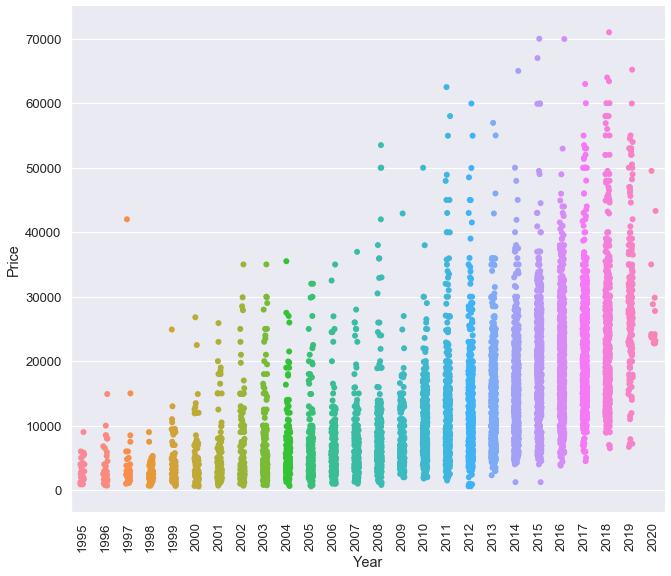

In [74]:
#Catplot by Year and Price.  Year is effectively a left-skewed histogram.  Looks like Year^2 could be a good feature!
sns.set(font_scale=1.2)
c = sns.catplot(x='Year',y='Price', data=vehicle, height=8, aspect=1.2, s=6)  #s changes marker size
c.set_xticklabels(rotation=90)
plt.show()

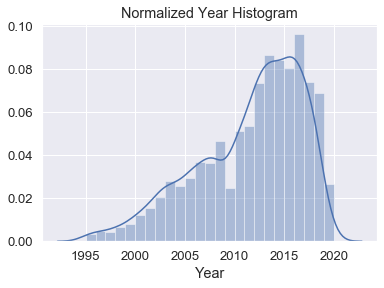

In [75]:
#Year histogram
y=sns.distplot(vehicle['Year'], bins=25, kde=True)
y.set_title("Normalized Year Histogram")
plt.show()

##  Add Features

In [76]:
#Make cab feature
cab_regex='\s\*{0,2}(SUPER\s?CAB|SUPER\s?CREW|SUPER\s?DUTY|CREW\s?CAB|REGULAR CAB|STANDARD CAB|CREW)'
cab_regex_space='\s\*{0,2}(SUPER\s?CAB|SUPER\s?CREW|SUPER\s?DUTY|CREW\s?CAB|REGULAR CAB|STANDARD CAB|CREW)\s'

Cab_Title = match_regex_patt(df=vehicle, target_col='Title', regex_patt=cab_regex)
vehicle['Cab_Title'] = Cab_Title

# Cab_Body = match_regex_patt(df=vehicle, target_col='Body', regex_patt=cab_regex)
# vehicle['Cab_Body'] = Cab_Body

#Scrub Cab
vehicle.loc[vehicle['Cab'].isna(), 'Cab'] = vehicle.loc[vehicle['Cab'].isna(), 'Cab_Title']
#vehicle.loc[vehicle['Cab'] == 'None', 'Cab'] = vehicle.loc[vehicle['Cab'] == 'None', 'Cab_Body']

#Drop redundant Cab columns
vehicle.drop(['Cab_Title'], axis='columns', inplace=True)

#Standardize Cab names
cab_dict={'Cab': {'standard cab' : 'regular cab','super cab' : 'supercab', 'super crew' : 'supercrew', 'crewcab' : 'crew cab', 'crew' : 'crew cab', 'superduty' : 'super duty'}}
vehicle.replace(cab_dict, inplace=True)

vehicle['Cab'].value_counts()

## In Title, 6678 missed matches for regex pattern: \s\*{0,2}(SUPER\s?CAB|SUPER\s?CREW|SUPER\s?DUTY|CREW\s?CAB|REGULAR CAB|STANDARD CAB|CREW).



None           6678
supercrew       669
supercab        189
crew cab        137
super duty       58
regular cab      50
Name: Cab, dtype: int64

In [77]:
#Make Year Squared feature to pull out right tail.
vehicle['Year' + '^2'] = vehicle['Year']**2

In [78]:
#Make Wreck feature.

#In Title and Body, check for Salvage/Wreck keywords.
regex_wreck='(SALVAGE|WRECK|ACCIDENT|CRASH|COLLISION|REBUILT TITLE|REBUILD TITLE)'

Wreck_Body=match_regex_patt(df=vehicle,target_col='Body',regex_patt=regex_wreck)
vehicle['Wreck_Body'] = Wreck_Body

Wreck_Title = match_regex_patt(df=vehicle, target_col='Title', regex_patt=regex_wreck)
vehicle['Wreck_Title'] = Wreck_Title

#Scrub Wreck
vehicle.loc[vehicle['Wreck'].isna(), 'Wreck'] = vehicle.loc[vehicle['Wreck'].isna(), 'Wreck_Body']
vehicle.loc[vehicle['Wreck'] == 'None', 'Wreck'] = vehicle.loc[vehicle['Wreck'] == 'None', 'Wreck_Title']

#Drop redundant Wreck columns
vehicle.drop(['Wreck_Title','Wreck_Body'], axis='columns', inplace=True)

vehicle['Wreck'].value_counts()

## In Body, 6540 missed matches for regex pattern: (SALVAGE|WRECK|ACCIDENT|CRASH|COLLISION|REBUILT TITLE|REBUILD TITLE).

## In Title, 7743 missed matches for regex pattern: (SALVAGE|WRECK|ACCIDENT|CRASH|COLLISION|REBUILT TITLE|REBUILD TITLE).



None             6524
accident          871
salvage           124
rebuilt title      85
wreck              68
collision          61
crash              38
rebuild title      10
Name: Wreck, dtype: int64

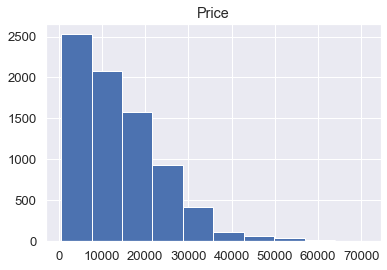

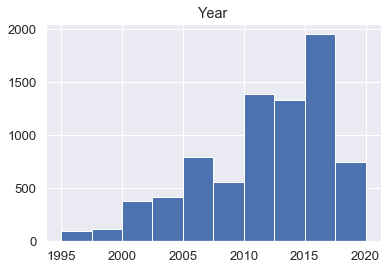

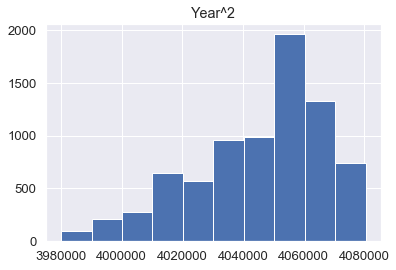

C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


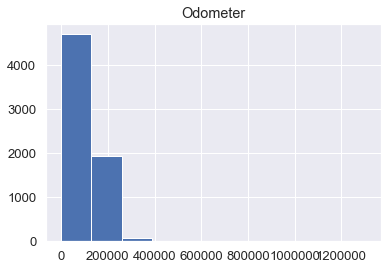

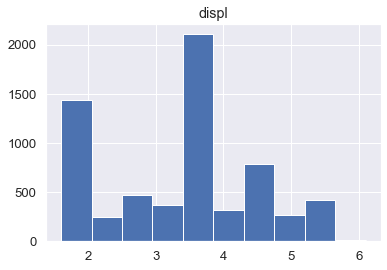

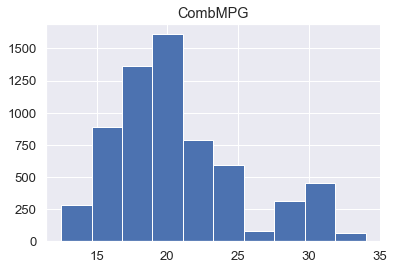

In [79]:
#Histogram of numeric features
for f in ['Price', 'Year', 'Year^2', 'Odometer', 'displ', 'CombMPG']:
    plt.hist(vehicle[f])
    plt.title(f)
    plt.show()

In [80]:
# Trim function adds Trim features.  Removes uncommon Model_Trim with low sample size.

def build_trim_feats(dframe, maxi_trims, min_trim_samp):
    '''
    Return DataFrame with new Trim features.
    
    Arguments
    ---------
    dframe: DataFrame containing model data
    maxi_trims: Max allowed trims -- 1 or 2.
    min_trim_samp: Min count of Model_Trim allowed.  Ex. Min 40 Mustang_GT samples.    
    '''
    
    df1=dframe.copy()
    
    #Populate max two Trim from RawMake.  Case Insensitive.
    trim_regex='\s\*{0,2}(INTERCEPTOR|CONVERTIBLE|COMMERCIAL|COMMERCIAL|PLATINUM|FLARESIDE|FASTBACK|HATCHBACK|LIGHTNING|PASSENGER|POLICE|ECOBOOST|EXTENDED|HERITAGE|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|TURBO|WAGON|BASE|BOSS|COUP|CONV|DUMP|KING|LIFT|MACH|4+4|4X4|BOX|CPE|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL\s|SES|SRW|STX|SVT|XLS|XLT|ZX3|ZX4|EL|SHO|V6|XL|GT|LX|RS|SE\s|ST\s|SD)'
    trim_RawMake = findall_regex_patt(df=df1, target_col='RawMake', regex_patt=trim_regex, max_items=maxi_trims, no_match_value='None')    
    df1['Trim_RawMake'] = trim_RawMake

    #Populate max two Trim from Title.  Case Insensitive.
    trim_Title = findall_regex_patt(df=df1, target_col='Title', regex_patt=trim_regex, max_items=maxi_trims, no_match_value='None')
    df1['Trim_Title'] = trim_Title

    #Populate max two Trim from Body.  Model is prefix of search pattern.
    trim_regex_spaces='\s(INTERCEPTOR|CONVERTIBLE|COMMERCIAL|COMMERCIAL|PLATINUM|FLARESIDE|FASTBACK|HATCHBACK|LIGHTNING|PASSENGER|POLICE|ECOBOOST|EXTENDED|HERITAGE|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|TURBO|WAGON|BASE|BOSS|COUP|CONV|DUMP|KING|LIFT|MACH|4+4|4X4|BOX|CPE|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL\s|SES|SRW|STX|SVT|XLS|XLT|ZX3|ZX4|EL|SHO|V6|XL|GT|LX|RS|SE\s|ST\s|SD)[,\s\.]'
    trim_Body=findall_body_regex_patt(df=df1,target_col='Body',regex_patt=trim_regex_spaces,max_items=maxi_trims, no_match_value='None')
    df1['Trim_Body'] = trim_Body

    #Scrub Trim.    
    df1.loc[df1['Trim'].isna(), 'Trim'] = df1.loc[df1['Trim'].isna(), 'Trim_RawMake']
    df1.loc[df1['Trim'] == 'None', 'Trim'] = df1.loc[df1['Trim'] == 'None', 'Trim_Title']
    df1.loc[df1['Trim'] == 'None', 'Trim'] = df1.loc[df1['Trim'] == 'None', 'Trim_Body']  

    #Drop redundant Trim columns.
    df1.drop(['Trim_RawMake','Trim_Title','Trim_Body'], axis='columns', inplace=True)

    #Create Model_Trim feature
    df1['Model_Trim'] = df1['Model'] + '_' + df1['Trim']

    #Remove df1 'Model_Trim' counts under threshold.
    thresh=min_trim_samp
    trim_counts=df1['Model_Trim'].value_counts()             
    print(f'\nDropping Trim with less than {thresh} examples:\n', list(trim_counts[trim_counts < thresh].index))
    trim_over_thresh = trim_counts[trim_counts >= thresh].index  #get thresh+ Model_Trim names
    df1= df1[df1['Model_Trim'].isin(trim_over_thresh)] #boolean filter for the thresh+ Model_Trim names
    print(f'\nOver {thresh} threshold trims:\n', df1['Model_Trim'].value_counts())
    
    return df1

In [81]:
vehicle.isna().sum()

URL_Vehicle            0
Title                  0
Location               0
Year                   0
Year_in_Title       7781
Odometer            1061
RawMake                0
Make                   0
Model                  0
Trim                7781
Seller                 0
Wreck                  0
Cab                    0
Price                  0
SubLoc                 0
Body                   0
AttribDictionary       0
ImageDictionary        0
VehicleID              0
VIN                    0
displ               1344
CombMPG             1344
DownFlag               0
Year^2                 0
dtype: int64

## Parameter Tuning  - Manual Version for Transparency

In [82]:
#-----------------HYPERPARAMETERS--------------------
# Use 1-2 Trims and min Trim sample size.
maxi_trims_used = 1
min_trim_sample = 40

#Target Encoding for category features.
min_samp_to_incl_class = 1
smoo_constraint = 0.1
#----------------------------------------------------

#Get Trim for hyperparameter pick: maxi_trims and min_trim_samp.
vehicle = build_trim_feats(dframe=vehicle, maxi_trims=maxi_trims_used, min_trim_samp=min_trim_sample)

## In RawMake, 5124 missed matches for regex pattern: \s\*{0,2}(INTERCEPTOR|CONVERTIBLE|COMMERCIAL|COMMERCIAL|PLATINUM|FLARESIDE|FASTBACK|HATCHBACK|LIGHTNING|PASSENGER|POLICE|ECOBOOST|EXTENDED|HERITAGE|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DUALLY|ENERGI|HARLEY|HYBRID|LARIAT|OUTLAW|RAPTOR|SALEEN|SHELBY|SPORTS|TREMOR|CARGO|COBRA|COUPE|EDDIE|SPORT|TURBO|WAGON|BASE|BOSS|COUP|CONV|DUMP|KING|LIFT|MACH|4+4|4X4|BOX|CPE|DRW|EXT|FWD|FX2|FX4|FX5|LTZ|MAX|SEL\s|SES|SRW|STX|SVT|XLS|XLT|ZX3|ZX4|EL|SHO|V6|XL|GT|LX|RS|SE\s|ST\s|SD).

## In Title, 2069 missed matches for regex pattern: \s\*{0,2}(INTERCEPTOR|CONVERTIBLE|COMMERCIAL|COMMERCIAL|PLATINUM|FLARESIDE|FASTBACK|HATCHBACK|LIGHTNING|PASSENGER|POLICE|ECOBOOST|EXTENDED|HERITAGE|TITANIUM|TX EDITION|BULLITT|CHASSIS|CONNECT|CUTAWAY|DIESELS|FLATBED|HIGHTOP|LIMITED|NATURAL|PREMIUM|SERVICE|SHUTTLE|UTILITY|ACCESS|BUCKET|DIESEL|DUALLY|ENERGI|HARLEY|HYBR

In [83]:
#Show Trim columns
vehicle[['RawMake','Title','Trim','Model_Trim']].head()

,RawMake,Title,Trim,Model_Trim
1,2006 Ford Focus SE,2006 Ford Focus SE,se,focus_se
9,2013 Ford Edge SEL automatic,2013 Ford Edge Black *Test Drive Today*,sel,edge_sel
14,1996 Ford F-150,"1996 Ford F-150 XLT 4x4 Long Bed, 88k original mile Pickup",xlt,f-150_xlt
16,1996 ford explorer,1996 Explorer 5.0 AWD,None,explorer_None
17,2012 Ford Transit Connect,2012 Ford Transit Connect XLT Cargo Van,connect,transit_connect


In [84]:
#Stratify data - depends on Trim pick.
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in sss.split(vehicle, vehicle['Model_Trim']):  #split indices as ilocs
    train = vehicle.iloc[train_index]
    test = vehicle.iloc[test_index]

#Drop irrelevant columns.
irrel_cols = ['URL_Vehicle', 'Title', 'Year_in_Title', 'RawMake', 'Make', 'SubLoc', 'Body',\
              'AttribDictionary', 'ImageDictionary', 'VehicleID', 'VIN', 'TrimAlternate', 'DownFlag']
train = train.drop(irrel_cols, axis='columns', errors='ignore')
test = test.drop(irrel_cols, axis='columns', errors='ignore')

#Target Encode category features with train: Price.
te_cols = ['Seller', 'Location', 'Model', 'Trim', 'Model_Trim', 'Wreck', 'Cab']
train, test=target_encode_categ(encode_cols=te_cols, train=train, test=test, target='Price',\
           encoder=TargetEncoder(cols=te_cols, min_samples_leaf=min_samp_to_incl_class, smoothing=smoo_constraint))


In [85]:
#Impute missing values - displ, CombMPG Odometer - by regressing on all other features.
train, test = multivar_impute(train, test,'Price')

#Drop any understated odometer values.
filt_used_under_1K = (train['Odometer'] < 1000) & (train['Year^2'] < 2020**2)
drop_indices = train[filt_used_under_1K].index
print(f'Drop {len(drop_indices)} incorrect low mileage from train:', drop_indices)
train = train.drop(index = drop_indices, errors = 'ignore')

filt_used_under_1K = (test['Odometer'] < 1000) & (test['Year^2'] < 2020**2)
drop_indices = test[filt_used_under_1K].index
print(f'# Drop {len(drop_indices)} incorrect low mileage from test:', drop_indices)
test = test.drop(index = drop_indices, errors = 'ignore')

#Drop anomaly odometer values.
filt_over_1M = train['Odometer'] > 400_000
drop_indices = train[filt_over_1M].index
print(f'# Drop {len(drop_indices)} incorrect high mileage from train:', drop_indices)
train = train.drop(index = drop_indices, errors = 'ignore')

filt_over_1M = test['Odometer'] > 400_000
drop_indices = test[filt_over_1M].index
print(f'# Drop {len(drop_indices)} incorrect high mileage from test:', drop_indices)
test = test.drop(index = drop_indices, errors = 'ignore')

Drop 55 incorrect low mileage from train: Int64Index([   16,  3081, 11486,  8733,  1321, 17575,  8463,  7145,  1533,
             7362, 13054, 12486, 12066,  9151,  8106,  3409,  3276,  1537,
            11485,  7128,  3631, 15809,  7707, 13038,  7150,  8121, 14929,
             4039, 15688,  7507,  7953,  5883,  5157,   827,   786, 10803,
             6054, 13552,  1641,  2949,  2951,  5473,  7851,  2694,  4359,
              736, 12497,   443,  3092, 18603, 10017,  8466, 14130,  3796,
            11487],
           dtype='int64')
# Drop 5 incorrect low mileage from test: Int64Index([11488, 8807, 15858, 5470, 11508], dtype='int64')
# Drop 11 incorrect high mileage from train: Int64Index([7853, 359, 12270, 15985, 158, 12799, 1932, 15109, 494, 2605, 4601], dtype='int64')
# Drop 1 incorrect high mileage from test: Int64Index([10445], dtype='int64')


In [86]:
train.head(1)

,Location,Year,Odometer,Model,Trim,Seller,Wreck,Cab,Price,displ,CombMPG,Year^2,Model_Trim
10889,13974.48075,2018.0,18815.0,7719.48564,10436.682889,16651.319942,16201.653543,13170.193466,13700.0,2.0,29.5,4072324.0,8301.585366


In [87]:
#***************User drops certain collinear or noise features.**************

user_drops = ['Location', 'Model', 'Trim', 'Year']
train = train.drop(user_drops, axis='columns', errors='ignore')
test = test.drop(user_drops, axis='columns', errors='ignore')

In [88]:
train.head(1)

,Odometer,Seller,Wreck,Cab,Price,displ,CombMPG,Year^2,Model_Trim
10889,18815.0,16651.319942,16201.653543,13170.193466,13700.0,2.0,29.5,4072324.0,8301.585366


### Train Plots

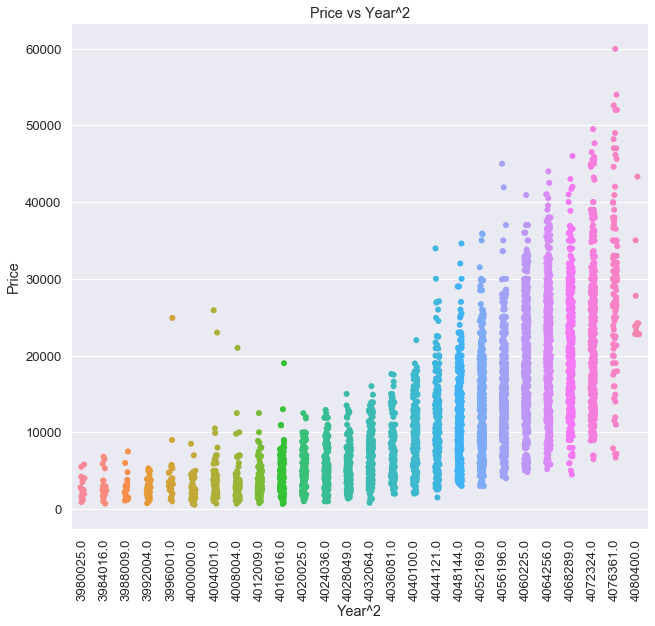

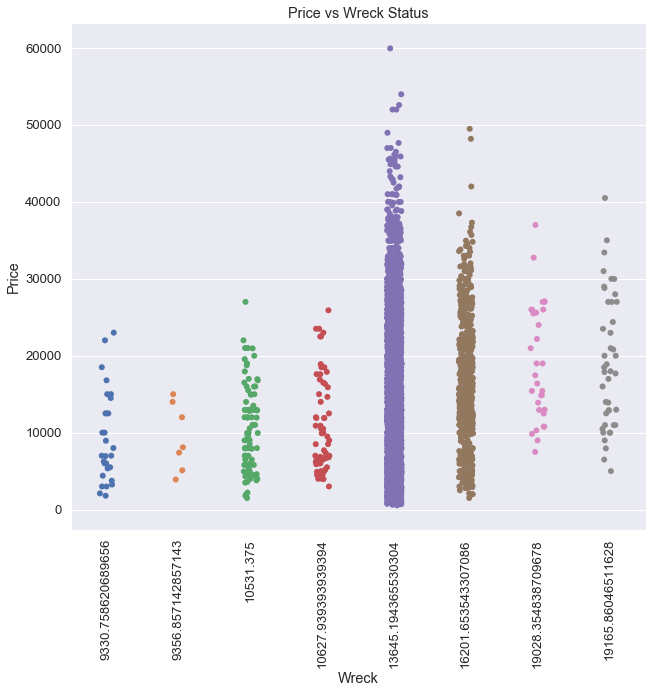

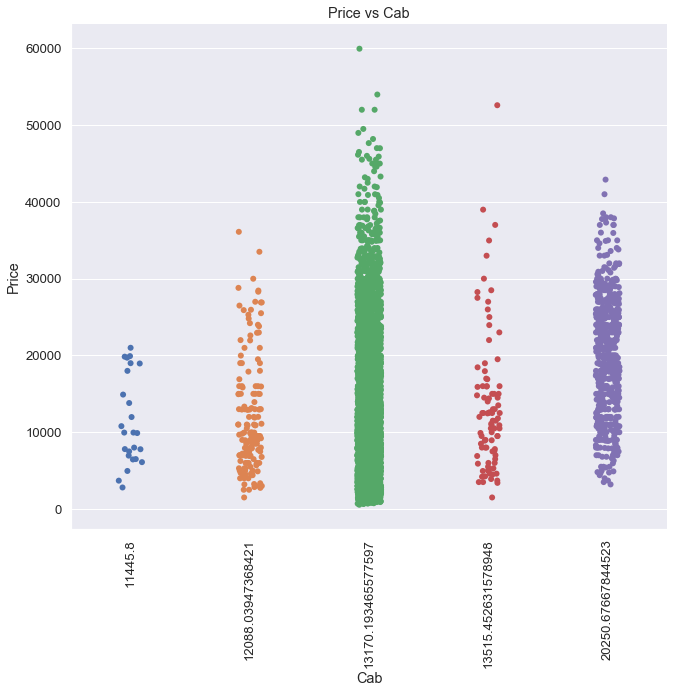

There are 45 unique Model_Trim combos.  High cardinality.


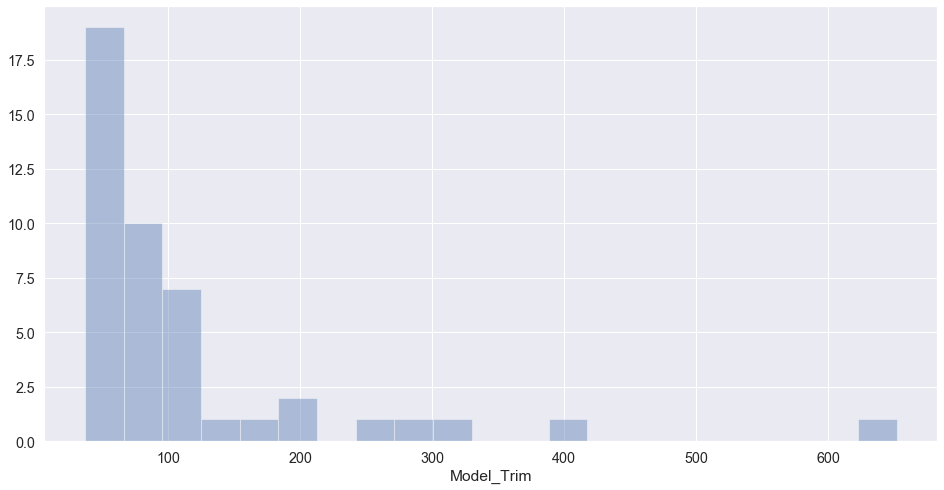

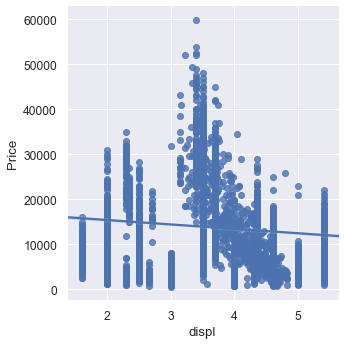

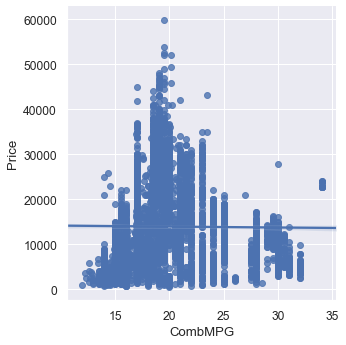

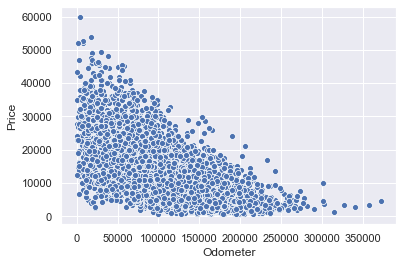

In [89]:
#PLOTS
mydf=train

#Catplot by Year^2 and Price.  Dumping uncommon Model_Trim removed most Price anomalies above "x^2 curve"!
sns.set(font_scale=1.2)
c2 = sns.catplot(x='Year^2',y='Price', data=mydf, height=8, aspect=1.2, s=6)  #s changes marker size
plt.title('Price vs Year^2')
c2.set_xticklabels(rotation=90)
plt.show()

#Catplot by Wreck and Price.
sns.set(font_scale=1.2)
c3 = sns.catplot(x='Wreck',y='Price', data=mydf, height=8, aspect=1.2, s=6)  #s changes marker size
plt.title('Price vs Wreck Status')
c3.set_xticklabels(rotation=90)
plt.show()

#Catplot by Cab and Price.
sns.set(font_scale=1.2)
c4 = sns.catplot(x='Cab',y='Price', data=mydf, height=8, aspect=1.2, s=6)  #s changes marker size
plt.title('Price vs Cab')
c4.set_xticklabels(rotation=90)
plt.show()

#Model_Trim has rare categories, so target encoding will need regularization.
print(f"There are {len(mydf['Model_Trim'].value_counts())} unique Model_Trim combos.  High cardinality.")
plt.figure(figsize=(16,8))
sns.set(font_scale=1.3)
sns.distplot(mydf['Model_Trim'].value_counts(), kde=False)
plt.show()
    
#Scatter by Displacement vs Price.
sns.set(font_scale=1.1)
sns.lmplot(x='displ',y='Price',data=mydf)  #s changes marker size
plt.show()

#Scatter by MPG vs Price.
sns.set(font_scale=1.1)
sns.lmplot(x='CombMPG',y='Price',data=mydf)  #s changes marker size
plt.show()
      
#Scatter by Odometer vs Price.  Will drop mileages over 400K.
sns.set(font_scale=1.0)
sns.scatterplot(x='Odometer',y='Price',data=mydf)  #s changes marker size
plt.show() 

In [90]:
train.describe()

,Odometer,Seller,Wreck,Cab,Price,displ,CombMPG,Year^2,Model_Trim
count,5057.000000,5057.000000,5057.000000,5057.000000,5057.000000,5057.000000,5057.000000,5.057000e+03,5057.000000
mean,99683.559066,13941.718526,13919.689024,13920.898959,13964.243425,3.487606,20.179035,4.048032e+06,13946.487026
std,56516.070304,3890.468394,1259.436690,2247.455413,9082.174334,1.046308,4.521295,2.049097e+04,5202.416376
min,4.000000,8356.856043,9330.758621,11445.800000,550.000000,1.600000,11.906480,3.980025e+06,2991.108696
25%,53990.000000,8356.856043,13645.194366,13170.193466,6499.000000,2.500000,17.000000,4.036081e+06,9822.666667
50%,95000.000000,16651.319942,13645.194366,13170.193466,12500.000000,3.500000,19.056990,4.052169e+06,15503.958904
75%,140000.000000,16651.319942,13645.194366,13170.193466,19500.000000,4.300000,22.000000,4.064256e+06,18862.694656
max,372000.000000,16651.319942,19165.860465,20250.676678,59950.000000,5.400000,34.000000,4.080400e+06,28326.594595


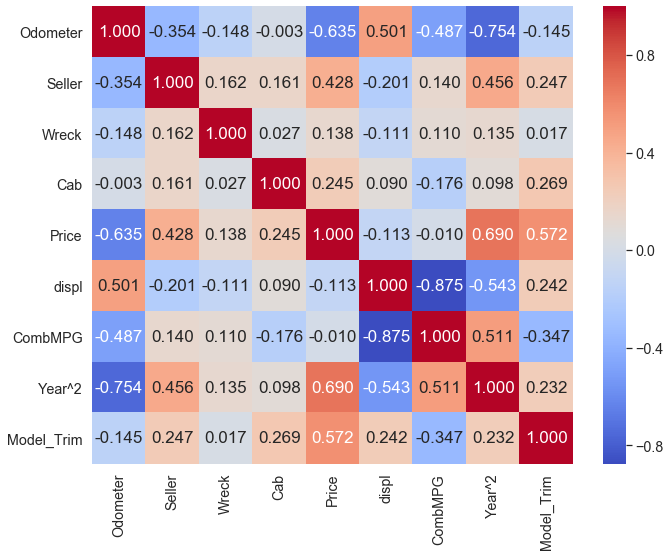

In [91]:
#Show correlation heatmap.  Keeping the collinear features may help prediction, while making the 
#linear regression coefficients less interpretable.
plt.figure(figsize=(10,8))
sns.set(font_scale=1.3)
sns.heatmap(train.corr(), cmap='coolwarm', annot=True, annot_kws={"size": 17}, fmt=".3f")
plt.tight_layout()

In [92]:
# #Investigate outliers revealed in pairplot.
# sns.set(font_scale=1.3)
# sns.pairplot(train)
# plt.show()

### Save Preprocessed data to PostgreSQL database

In [93]:
#Save tables to PostgreSQL database.
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import JSON, JSONB
engine=create_engine("postgresql://postgres@localhost:5432/postgres")

#Write vehicle table with json
vehicle.to_sql(name='vehicle', con=engine, if_exists='replace', index=True,\
               dtype={'AttribDictionary': JSONB, 'ImageDictionary': JSONB})

#Write train and test
train.to_sql(name='trainClean', con=engine, if_exists='replace', index=True)
test.to_sql(name='testClean', con=engine, if_exists='replace', index=True)

In [94]:
print('train shape:', train.shape, '| test shape:', test.shape)

train shape: (5057, 9) | test shape: (564, 9)


In [95]:
vehicle.Model_Trim.value_counts()

f-150_xlt              728
f-150_None             453
f-150_lariat           354
mustang_gt             322
focus_se               274
f-150_xl               225
explorer_xlt           213
fusion_se              193
escape_se              145
fusion_None            128
escape_None            122
mustang_None           122
explorer_limited       115
f-150_4x4              112
f-150_platinum         112
focus_None             111
f-150_fx4              106
edge_sel               102
mustang_v6              99
mustang_ecoboost        97
fiesta_se               97
transit_connect         93
expedition_xlt          93
f-150_king              92
explorer_None           83
explorer_sport          81
expedition_None         67
expedition_el           66
ranger_None             65
transit_cargo           64
expedition_eddie        63
escape_titanium         62
edge_limited            61
f-150_fx2               61
expedition_limited      54
f-150_stx               54
taurus_None             51
e